In [2]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
import time
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

Lectura de Corpus

In [4]:
nltk.download('twitter_samples')

[nltk_data] Error loading twitter_samples: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

In [5]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


Preprocesamiento


1. LowerCase
2. Lematización / Stemming
3. Remover stopword
4. Remover signos de puntuación
4. Remover urls y manejadores





In [6]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}]}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)


In [7]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

Create Vocabulary and frequency dictionaries

In [8]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)
all_tweets = norm_pos + norm_neg
at = [w for tweet in all_tweets for w in tweet]
fd = nltk.FreqDist(at)
vocabulary = sorted(list(fd.keys()))

print('\nThe vocabulary has %d words.\n' %len(vocabulary))



The vocabulary has 11260 words.



In [9]:
X_features = []
for text in all_tweets:
  vector = [1] # initialize in 1 ?
  for voc in vocabulary:
    # In vector saves a list of vocabulary's length. 
    # Iterate each vocabulary word and count in each text list
    vector.append(text.count(voc))
  X_features.append(vector)

print('\nX_features matrix has m = %d examples (rows).\n' %len(X_features))
print('and  n = %d features (columns).\n' %len(X_features[0]))


X_features matrix has m = 10000 examples (rows).

and  n = 11261 features (columns).



In [10]:
tags = [1]*len(pos_tweets) + [0]*len(neg_tweets)

In [18]:
"""Shuffle list"""
tuple_list = list(zip(X_features, tags)) #list of tuples (X,y)
random.seed(30)
random.shuffle(tuple_list)
X_, y_ = zip(*tuple_list)

X = list(X_)
y = list(y_)

In [19]:
"""split corpus into test(20%) and train(80%)"""
test_percentage = 0.2
split = int(len(X) * test_percentage)
X_test = X[:split]
y_test = y[:split]
X_train = X[split:]
y_train = y[split:]

m_train = len(X_train) #number of examples in X_train
m_test = len(X_test) #number of examples in X_test
n = len(X_train[0]) #features

In [20]:
"""Convert to array"""
import numpy as np
X_train = np.array(X_train).T
X_test = np.array(X_test).T
y_train = np.array(y_train)
y_test = np.array(y_test)
print('features: ', n)
print('shape X_train: ', X_train.shape)
print('shape X_test: ', X_test.shape)

y_train = y_train.reshape((m_train, 1))
y_test = y_test.reshape((m_test, 1))
print('shape y_train: ', y_train.shape)
print('shape y_test: ', y_test.shape)

features:  11261
shape X_train:  (11261, 8000)
shape X_test:  (11261, 2000)
shape y_train:  (8000, 1)
shape y_test:  (2000, 1)


In [21]:
def sigmoid(z):
  sigmoide = np.where(z < 0, np.exp(z)/(1 + np.exp(z)), 1/(1 + np.exp(-z)))
  return sigmoide
  #return 1/(1 + np.exp(-z)) 

In [22]:
def log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps) #limitar los valores del array en el rango eps y 1 - eps
    loss = - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    return np.mean(loss)

In [23]:
def gradient_descent(h_theta, y, X):
  return (1/len(y)) * np.dot((h_theta - y).T,X.T) # 1xm dot mxn ->1xn

In [24]:
""" Train """
epochs = 1500
learning_rate = 2
costs = []
theta = np.zeros((n,1)) #-> nx1

start_time = time.time()
for i in range(epochs):
  z = np.dot(theta.T, X_train) #->1xm
  h_theta = sigmoid(z.T)#->mx1, h_theta or y_pred
  #Calculate cost
  cost = log_loss(y_train,h_theta) #scalar
  costs.append(cost)

  if i%100 == 0:
    print('Cost in epoch', i, 'is', cost)
    
  #Gradient descent
  d_theta = gradient_descent(h_theta, y_train, X_train).T #->nx1
  theta = theta - learning_rate * d_theta #->nx1


end_time = time.time()
epoch_time = end_time - start_time
print("Execution time : {:.2f} seconds".format(epoch_time))
  

Cost in epoch 0 is 0.6931471805599454
Cost in epoch 100 is 0.09474352676027303
Cost in epoch 200 is 0.08158748292342222
Cost in epoch 300 is 0.07467276440895994
Cost in epoch 400 is 0.06989767411735391
Cost in epoch 500 is 0.06621519899880786
Cost in epoch 600 is 0.0632015568744403
Cost in epoch 700 is 0.06064297605601169
Cost in epoch 800 is 0.05841617684409844
Cost in epoch 900 is 0.05644329243490766
Cost in epoch 1000 is 0.054671784821783136
Cost in epoch 1100 is 0.05306438977148867
Cost in epoch 1200 is 0.05159362469220487
Cost in epoch 1300 is 0.050238578303353786
Cost in epoch 1400 is 0.04898292919398681
Execution time : 2284.68 seconds


Text(0.5, 1.0, 'Learning curve')

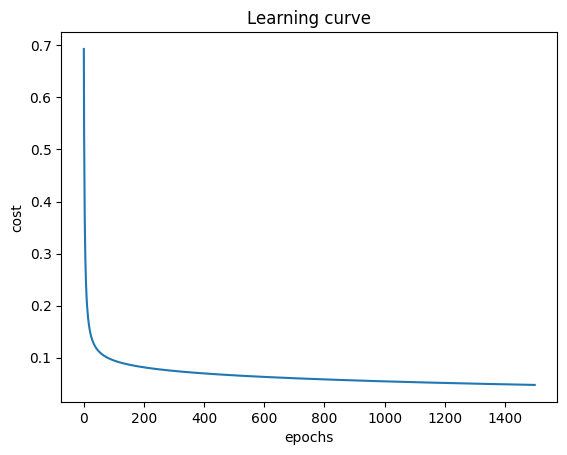

In [25]:
#Plot train cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning curve")

In [26]:
def evaluation(theta,X):
  #X -> nxm
  #theta.T ->1xn
  z = np.dot(theta.T, X) #->1xm
  return sigmoid(z.T)#->mx1

In [27]:
def classify_tag(y_pred_list,threshold):
  return [1 if y >= threshold else 0 for y in y_pred_list]

In [28]:
def confusion_matrix_values(y_pred, y_label):
  TP, FN, FP, TN = 0 , 0 , 0, 0
  for i in range(len(y_pred)):
    if y_pred[i] == 1 and  y_label[i] == 1:
      TP = TP + 1
    elif y_pred[i] == 1 and y_label[i] == 0:
      FP = FP + 1
    elif y_pred[i] == 0 and y_label[i] == 1:
      FN = FN + 1
    else:
      TN = TN + 1
  return TP, FN, FP, TN

In [29]:
"""Measures"""

def measures(TP, FN, FP, TN):
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  fallout = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F = (precision * recall) / (precision + recall)
  F1 = (2 * precision * recall)/(precision + recall)
  print("Presicion: ", precision)
  print("Recall: ", recall)
  print("F: ", F)
  print("F1: ", F1)
  print("Fallout: ", fallout)
  print("Accuracy: ", accuracy)

In [30]:
"""Evaluation for Train"""

threshold = 0.5
y_train_pred_prob = evaluation(theta,X_train)
y_train_pred = classify_tag(y_train_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_train_pred, y_train)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

3965 20 75 3940
Presicion:  0.9814356435643564
Recall:  0.9949811794228356
F:  0.49408099688473517
F1:  0.9881619937694703
Fallout:  0.0186799501867995
Accuracy:  0.988125


In [31]:
"""Evaluation for Test"""

y_test_pred_prob = evaluation(theta,X_test)
y_test_pred = classify_tag(y_test_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_test_pred, y_test)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

989 26 53 932
Presicion:  0.9491362763915547
Recall:  0.9743842364532019
F:  0.48079727758872143
F1:  0.9615945551774429
Fallout:  0.05380710659898477
Accuracy:  0.9605


Usando scikit-learn

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=50)
target_names = ['class 0', 'class 1']

In [34]:
# Creamos el modelo de regresión logística
modelo = LogisticRegression()
# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)
# Evaluamos el modelo
puntaje = modelo.score(X_test, y_test)
# Imprimimos el puntaje obtenido
print("Puntaje: ", puntaje)
print(classification_report(y_test, predicciones, target_names=target_names, digits=4))

Puntaje:  0.956
              precision    recall  f1-score   support

     class 0     0.9696    0.9401    0.9546       985
     class 1     0.9435    0.9714    0.9573      1015

    accuracy                         0.9560      2000
   macro avg     0.9566    0.9558    0.9560      2000
weighted avg     0.9564    0.9560    0.9560      2000

